# This notebook demonstrates how to do symbolic and numeric Lorentz transformations of 4-tensors

In [1]:
# setting up the stage

%pylab nbagg

from sympy.tensor.tensor import TensorIndexType, tensor_indices, tensorhead, TensorManager
from sympy import symbols, sqrt, simplify, init_printing, Order, oo, series
from sympy.matrices import eye

import numpy as np
import scipy.constants as sc
from scipy.integrate import dblquad, nquad, simps
from scipy import interpolate
from mpl_toolkits.mplot3d import axes3d

# the following commands allow to produce a nice pdf version of the notebook with figures:
from matplotlib.pyplot import *
%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

fsize=20
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'

# begin counting figures
ifig=0
for i in range(0,10000):
    plt.close(i)

def select_fig(ifig,close_fig=True):
    if close_fig:
        plt.close(ifig)
    plt.figure(ifig)

init_printing(pretty_print=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# defining a Lorentz-type tensor
TensorManager.clear()
Lorentz = TensorIndexType('Lorentz', dummy_fmt='L')
Lorentz.data = [1, -1, -1, -1]
TensorIndexType(Lorentz, 0)
Lorentz.data

array([[1, 0, 0, 0],
       [0, -1, 0, 0],
       [0, 0, -1, 0],
       [0, 0, 0, -1]], dtype=object)

In [3]:
# defining tensor indices; do not use them as loop variables!!!
i, j, k, l = tensor_indices('i:4', Lorentz)  

In [4]:
c = symbols('c', positive=True)  # the speed of light in vacuum

g, vx, vy, vz, v, bx, by, bz, b = symbols('gamma v_x v_y v_z v beta_x beta_y beta_z beta')

v = sqrt(vx**2+vy**2+vz**2)  # boost velocity
g = 1/sqrt(1-(vx**2+vy**2+vz**2)/c**2)  # Lorentz gamma factor
bx = vx/c; by = vy/c; bz = vz/c  # Cartesian projections of Lorentz beta

In [5]:
# Lorentz transformation tensor 
L = tensorhead('L', [Lorentz, Lorentz], [[1],[1]])

L(i,j).data = [[g, g*bx, g*by, g*bz],\
               [g*bx, 1+(g-1)*vx**2/v**2,(g-1)*vx*vy/v**2, (g-1)*vx*vz/v**2],\
               [g*by, (g-1)*vx*vy/v**2, 1+(g-1)*vy**2/v**2, (g-1.)*vy*vz/v**2],\
               [g*bz, (g-1)*vx*vz/v**2, (g-1)*vy*vz/v**2, 1+(g-1)*vz**2/v**2]]

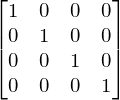

In [6]:
delta = eye(4)  # Kronecker delta as matrix
delta

In [7]:
eta = np.asmatrix(Lorentz.data)  # Minkowski metric tensor as matrix; this assignment doesn't always work!

#eta = np.matrix([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,-1]])  # Minkowski metric tensor as matrix
eta

matrix([[1, 0, 0, 0],
        [0, -1, 0, 0],
        [0, 0, -1, 0],
        [0, 0, 0, -1]], dtype=object)

In [8]:
# Python implementation of Levi-Civita tensor in arbitrary dimensions, using array representation
# LeviCivitaTensor(d) returns a NumPy array of dimension   d x d x ... x d
#                                                         (    d times    ) 
# Reference: https://en.wikipedia.org/wiki/Levi-Civita_symbol#Generalization_to_n_dimensions
# Jayson Paulose <jaysonpaulose@gmail.com>

import numpy as np

def perm_parity(a,b):
    """Modified from
    http://code.activestate.com/recipes/578236-alternatve-generation-of-the-parity-or-sign-of-a-p/"""
    
    a = list(a)
    b = list(b)

    if sorted(a) != sorted(b): return 0
    inversions = 0
    while a:
        first = a.pop(0)
        inversions += b.index(first)
        b.remove(first)
    return -1 if inversions % 2 else 1

def loop_recursive(dim,n,q,s,paritycheck):
    if n < dim:
        for x in range(dim):
            q[n] = x
            loop_recursive(dim,n+1,q,s,paritycheck)
    else:
        s.append(perm_parity(q,paritycheck))
        
def LeviCivitaTensor(dim):
    qinit = np.zeros(dim)
    paritycheck = range(dim)
    flattened_tensor = []
    loop_recursive(dim,0,qinit,flattened_tensor,paritycheck)

    return np.reshape(flattened_tensor,[dim]*dim)

eps = LeviCivitaTensor(4)  # 4-dim Levi-Civita tensor

In [9]:
LM = L(i,j).get_matrix()  # Lorentz transformation matrix
LM1 = L(-i,-j).get_matrix()  # inverse Lorentz matrix
LM2 = LM.subs({vx:-vx, vy:-vy, vz:-vz})  # this is also inverse Lorentz matrix

# check if it's true

print ("Are LM1 and LM2 equal matrices?\n", "This is", (LM1 == LM2), "!")

print ("Is the product of LM and LM1 equal to Kronecker delta\n", simplify(LM*LM1) == delta)

Are LM1 and LM2 equal matrices?
 This is True !
Is the product of LM and LM1 equal to Kronecker delta
 True


In [10]:
LM.det()  # Lorentz matrix determinant

In [11]:
# 4-radius vector
xt = tensorhead('xt', [Lorentz], [[1]])
t, x0, x1, x2, x3, V = symbols('t ct x y z V', positive=True)
xt.data = [x0, x1, x2, x3]

print (xt(i).data)  # its contravariant components
print (xt(-i).data)  # its covariant components

x_umu = xt(i).get_matrix()  # umu stands for upper mu
print (x_umu)

x_lmu = xt(-i).get_matrix()  # lmu stands for lower mu
print (x_lmu)

[ct x y z]
[ct -x -y -z]
Matrix([[ct], [x], [y], [z]])
Matrix([[ct], [-x], [-y], [-z]])


Time transformation for parallel ($X=X'$, $\mathbf{V}=V\mathbf{e}_x$) motion.

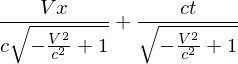

In [12]:
ctp=((LM*x_umu).subs({vx:V, vy:0, vz:0})[0])  # time transformation for parallel motion
ctp

### Make a plot showing Earth time $t$ as a function of $\beta$ for a given travel time $\tau$

$$ t = \frac{\tau}{\sqrt{1-\beta^2}}.$$

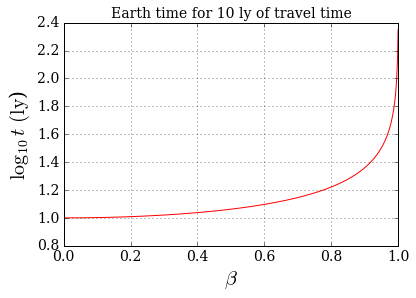

In [13]:
travel_time = 10  # light years (ly)
earth_time = ctp.subs({x0:travel_time, x1:0})

nb = 1000
beta_max = 0.999
beta = np.linspace(0,beta_max,nb)
t_plot = np.linspace(0,0,nb)
for n in range(nb):
    t_plot[n] = earth_time.subs({V:beta[n]*c})
    t_plot[n] = np.log10(t_plot[n])
    
ifig=ifig+1
close(ifig),select_fig(ifig)
plot(beta,t_plot,'r')
xlabel("$\\beta$",fontsize=fsize)
ylabel("$\log_{10}\,t\ (\mathrm{ly}$)",fontsize=fsize)
title("Earth time for "+str(travel_time)+" ly of travel time",fontsize=14)
grid()
show()

### Check that the interval remains invariant in the Lorentz transformations ($s^2 = s'^2$?)

Lorentz transformations of contravariant components of a 4-radius vector:

$$ x^{\mu} = \Lambda^{\mu}_{\ \nu'}\,{x'}^{\nu'}. $$
Dot product of original 4-radius vector:

$$ s^2 = x^{\mu} x_{\mu} = x^{\mu} \eta_{\mu\nu}\,x^{\nu}.$$

In [14]:
# in expression xp_umu p stands for prime and umu for upper mu

xp_umu = LM*x_umu  # Lorentz transformations of contravariant components of 4-radius vector

s2 = x_umu.transpose()*(eta*x_umu)  # dot product of original 4-radius vector
print ("s2 =", s2)

sp2 = simplify(xp_umu.transpose()*(eta*xp_umu))  # dot product of transformed 4-radius vector
print ("sp2 =", sp2)

s2 = Matrix([[ct**2 - x**2 - y**2 - z**2]])
sp2 = Matrix([[1.0*ct**2 - 1.0*x**2 - 1.0*y**2 - 1.0*z**2]])


In [15]:
(xt(-i)*xt(i)).data  # this is also s**2

Let's demonstrate that $\eta_{\mu\nu}\Lambda^\nu_{\ \alpha'}\eta^{{\alpha'}{\beta'}} = 
((\Lambda^{-1})^\mathrm{T}) = \Lambda^{-1}$.

In [16]:
print (eta*LM*eta == LM1.transpose())
print (eta*LM*eta == LM1)
print (LM1 == LM1.transpose())

True
True
True


### The 4-velocity

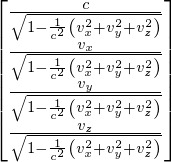

In [17]:
# 4-velocity 
U = tensorhead('U', [Lorentz], [[1]])
U.data = [c, vx, vy, vz]

U_umu = g*U(i).get_matrix()  # recall that g is gamma factor for (vx,vy,vz)
U_umu

In [18]:
simplify(U_umu.transpose()*(eta*U_umu))  # dot product of 4-velocity

### The energy-momentum 4-vector

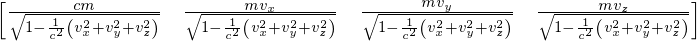

In [19]:
m = symbols('m', positive=True)  # particle's rest mass
P_umu = m*U_umu  # 4-momentum (energy-momentum)
P_umu.transpose()

In [20]:
simplify(P_umu.transpose()*(eta*P_umu))

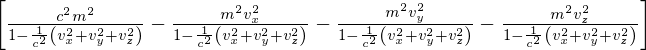

In [21]:
P_umu.transpose()*(eta*P_umu)

In [22]:
# Energy-momentum tensor
P = tensorhead('P', [Lorentz], [[1]])
E, px, py, pz = symbols('E p_x p_y p_z', positive=True)
P.data = [E, px, py, pz]
P**2

The following calculations are relevant to the solution of problem 3 from homework assignment 1.

In [23]:
# Cartesian projections of the boost velocity V
Vx, Vy, Vz = symbols('V_x V_y V_z', positive=True)
LMV = LM.subs({vx:Vx, vy:Vy, vz:Vz})
LMV2 = LMV.subs({(Vx**2+Vy**2+Vz**2):V**2})

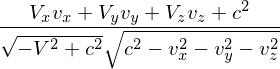

In [24]:
expr0 = simplify((LMV2*U_umu)[0]/c)  # new gamma
expr0

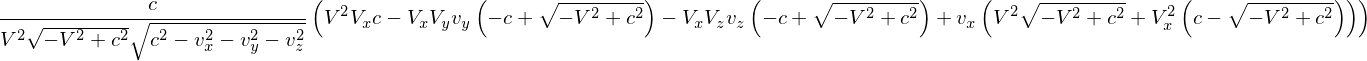

In [25]:
expr1 = simplify((LMV2*U_umu)[1])  # new velocity x component
expr1

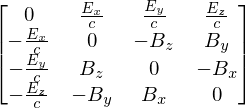

In [26]:
# Cartesian projections of electric nad magnetic fields
Ex, Ey, Ez, Bx, By, Bz = symbols('E_x E_y E_z B_x B_y B_z')

# electromagnetic field strength tensor 
F = tensorhead('F', [Lorentz, Lorentz], [[1],[1]])
F(-i, -j).data = [[0, Ex/c, Ey/c, Ez/c],\
                    [-Ex/c, 0, -Bz, By],\
                    [-Ey/c, Bz, 0, -Bx],\
                    [-Ez/c, -By, Bx, 0]]
FM1 = F(-i,-j).get_matrix()
FM1

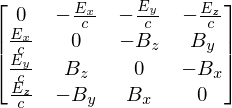

In [27]:
FM = F(i,j).get_matrix()
FM

Calculation of Lorentz invariants $A=F_{\mu\nu}F^{\mu\nu}=\frac{2}{c^2}(c^2B^2-E^2)$ and $B=F_{\mu\nu}\widetilde{F}^{\,\mu\nu}=-\frac{4}{c}(\mathbf{E}\mathbf{B})$, 
where the dual field strength tensor $\widetilde{F}^{\,\mu\nu}=\frac{1}{2}\varepsilon^{\,\mu\nu\rho\sigma}F_{\rho\sigma}$.

In [28]:
A = F(-i,-j)*F(i,j)  # recall that negative indices mean covariant ones

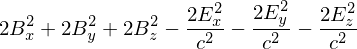

In [29]:
A.data

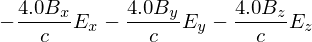

In [30]:
B = symbols('B')
B = 0
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                B = B+FM1[i1,i2]*(0.5*eps[i1,i2,i3,i4]*FM1[i3,i4])
B